# Chapter 6

What I expect from this chapter:

- Learn what fine-tuning is for LLMs.
- Learn what can I achieve by finetunning an LLM. How is it better than the original model?
- Learn how much data do I need to fine-tune an LLM.


In [44]:
import requests
import zipfile
from pathlib import Path
import io

import pandas as pd
import torch
from torch.utils.data import Dataset
import tiktoken

LLM fine tuning generally split in two types:

- **Instruction**: Learn to follow instructions, rather than just complete text.
- **Classification**: Learn to classify text in predefined categories.


## Data preprocessing


In [45]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
name = "SMSSpamCollection"

The dataset is only 200kb, so consider loading into memory instead of extracting the content.


In [46]:
def fetch_data(url: str, name: str) -> pd.DataFrame:
    res = requests.get(url)
    zip = zipfile.ZipFile(io.BytesIO(res.content))
    df = pd.read_csv(zip.open(name), sep="\t", header=None, names=["Label", "Text"])
    return df

In [47]:
df = fetch_data(url, name)

In [48]:
df.shape

(5572, 2)

In [49]:
df["Label"].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

Dataset unbalanced. Contains much more ham than spam.

We'll bruteforce balance it.


In [50]:
def extract_balanced_dataset(df: pd.DataFrame) -> pd.DataFrame:
    spam_subset = df.query("Label == 'spam'")
    ham_subset = df.query("Label == 'ham'").sample(
        spam_subset.shape[0], random_state=36
    )

    balanced_df = pd.concat([spam_subset, ham_subset], ignore_index=True)
    return balanced_df

In [51]:
# Skipping the balancing step to see difference in results
balanced_df = df.copy()

# Now, let's create a target value by converting tags to binary values.
balanced_df["Label"] = balanced_df["Label"].map({"spam": 1, "ham": 0}).astype(int)

In [52]:
def random_split(
    df: pd.DataFrame, train_frac: float, validation_frac: float
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    # Randomize dataset order
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(df.shape[0] * train_frac)
    validation_end = train_end + int(df.shape[0] * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

In [53]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [54]:
data_path = Path().cwd().parent / "data"

In [55]:
if not data_path.exists():
    data_path.mkdir()

train_df.to_csv(data_path / "train.csv", index=None)
validation_df.to_csv(data_path / "validation.csv", index=None)
test_df.to_csv(data_path / "test.csv", index=None)

## Data loaders


To combine multiple training examples in a batch, they must have **the same length**.

So do one of the following:

- Truncate all messages to length of shortest.
- Pad all messagest to length of largest.

Choose the later to not lose information. Use 50256 token (endoftext) as padding.


In [56]:
tokenizer = tiktoken.get_encoding("gpt2")
tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})

[50256]

In [57]:
class SpamDataset(Dataset):
    def __init__(
        self,
        csv_file: str,
        tokenizer: tiktoken.Encoding,
        max_length: int | None = None,
        pad_token_id: int = 50256,
    ):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate text
            self.encoded_texts = [
                encoded_texts[: self.max_length] for encoded_texts in self.encoded_texts
            ]
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        encoded = self.encoded_texts[index]
        label = self.data.at[index, "Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            max_length = max(max_length, len(encoded_text))
        return max_length

In [58]:
# Validation and Test datasets that are longer than training are truncated.

train_dataset = SpamDataset(
    csv_file=data_path / "train.csv", max_length=None, tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file=data_path / "validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer,
)
test_dataset = SpamDataset(
    csv_file=data_path / "test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer,
)

In [59]:
train_dataset._longest_encoded_length()

257

In [60]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8  # how many objects to train at the same time

# shuffle=True so model doesn't learn anything from order of docuemnts

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [61]:
for input_batch, target_batch in train_loader:
    pass

print(input_batch.shape)
print(target_batch.shape)

torch.Size([8, 257])
torch.Size([8])


In [62]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

487
70
140


In [63]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpd-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [64]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


In [ ]:
from previous_chapters import generate_text_simple, text_to_token_ids, token_ids_to_text

In [ ]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"],
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


Always have a base to compare. Start by checking out if model is capable of classifying spam by default.


In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
    " Answer with 'yes' or 'no'."
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"],
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes'


Model is not good at following instructions. It hasn't beenn trained to do so!


In [ ]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [ ]:
# Freezing the model
for param in model.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], out_features=num_classes
)

In [ ]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

In [ ]:
with torch.no_grad():
    outputs = model(inputs)

In [ ]:
print(outputs)
print(outputs.shape)

tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
torch.Size([1, 4, 2])


For each input token, one output.

The last result contains the most information, as it has information from all previous tokens, due to how the atention mecanism works.


In [ ]:
# Define the loss function (remember, must be differentiable)


# minimize the cross entropy loss
def calc_loss_batch(input_batch, target_batch, model, device) -> torch.Tensor:
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

In [ ]:
print(train_loss)
print(val_loss)
print(test_loss)

2.0730717897415163
2.5822011470794677
2.833951997756958


Classification accuracy is non-diferentaible, so only use for evaluation, not for fine-tunning.


In [ ]:
@torch.no_grad()  # Disable gradient tracking for efficiency
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [ ]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

In [ ]:
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 55.00%
Test accuracy: 51.25%


In [ ]:
# Finetuning the model

In [ ]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [40]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous epoch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            examples_seen += input_batch.shape[
                0
            ]  # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [41]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.779, Val loss 2.541
Ep 1 (Step 000050): Train loss 0.834, Val loss 0.846
Ep 1 (Step 000100): Train loss 0.661, Val loss 0.691
Training accuracy: 72.50% | Validation accuracy: 57.50%
Ep 2 (Step 000150): Train loss 0.696, Val loss 0.704
Ep 2 (Step 000200): Train loss 0.673, Val loss 0.680
Ep 2 (Step 000250): Train loss 0.675, Val loss 0.679
Training accuracy: 65.00% | Validation accuracy: 60.00%
Ep 3 (Step 000300): Train loss 0.671, Val loss 0.671
Ep 3 (Step 000350): Train loss 0.653, Val loss 0.671
Training accuracy: 62.50% | Validation accuracy: 50.00%
Ep 4 (Step 000400): Train loss 0.604, Val loss 0.667
Ep 4 (Step 000450): Train loss 0.666, Val loss 0.656
Ep 4 (Step 000500): Train loss 0.620, Val loss 0.655
Training accuracy: 75.00% | Validation accuracy: 70.00%
Ep 5 (Step 000550): Train loss 0.653, Val loss 0.646
Ep 5 (Step 000600): Train loss 0.624, Val loss 0.646
Training accuracy: 80.00% | Validation accuracy: 75.00%
Training completed in 5.08 minu

In [42]:
import matplotlib.pyplot as plt


def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.show()

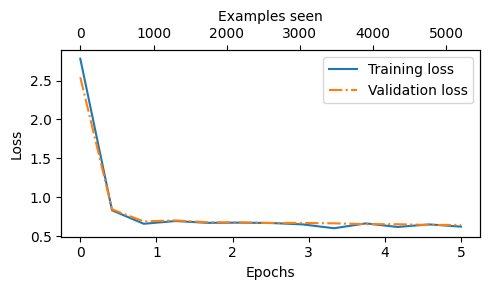

In [44]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

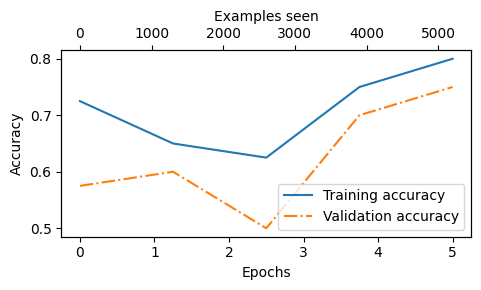

In [45]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [47]:
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Test accuracy: 85.00%


In [48]:
def classify_review(
    text, model, tokenizer, device, max_length=None, pad_token_id=50256
):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # Truncate sequences if they too long
    input_ids = input_ids[: min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(
        0
    )  # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "Positive" if predicted_label == 1 else "Negative"

In [49]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(
    classify_review(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

Positive


In [50]:
text_2 = (
    "Hey, just wanted to check if we're still on" " for dinner tonight? Let me know!"
)

print(
    classify_review(
        text_2, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

Negative


In [51]:
torch.save(model.state_dict(), "review_classifier.pth")

## How do these results compare to vanilla gpt3.5?


In [28]:
import openai
import instructor
from pydantic import BaseModel

client = instructor.from_openai(openai.OpenAI())

In [31]:
class IsSpamResponse(BaseModel):
    is_spam: bool

In [37]:
def classify_with_openai(message: str, client) -> bool:
    res = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You're a spam classifying expert."},
            {"role": "user", "content": message},
        ],
        response_model=IsSpamResponse,
    )
    res = res.is_spam
    return res

In [33]:
test = pd.read_csv(data_path / "test.csv")

In [43]:
# Takes some time, make async for immediate response.
results = test.assign(pred=lambda df: df["Text"].apply(classify_with_openai, client=client))

KeyboardInterrupt: 

In [42]:
print(f"GPT3.5 accuracy: {results['Label'].eq(results['pred']).mean():.1%}")

GPT3.5 accuracy: 79.0%


The model we finetuned is better at predicting spam than vanilla GPT3.5!

## What happens with results if we don't balance the classes?
